<a href="https://colab.research.google.com/github/panford/ML4DD/blob/main/Notebook_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Models for Molecule Generation
( Using VAE - TensorFlow/ keras implementation)

**Author**: Kobby Panford-Quainoo [(panford.github.io)](https://panford.github.io)

**Institution:** African Institute for Mathematical Sciences - African Masters in Machine Intelligence (AIMS-AMMI)

**Workshop:** International E-workshop on Machine Learning for Drug Discovery, India (05/21)



---

In this tutorial, we will look at how to generate molecules from the SMILES dataset using variational Autoencoders (VAEs). Let's begin by installing condalab which will allow us to later install RDKit.

In [ ]:
#@title Install condalab: We need to install condalab in order to install RDKits with Anaconda
!pip install -q condacolab

import condacolab
condacolab.install()

!conda install -q rdkit

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:31
🔁 Restarting kernel...
Solving environment: ...working... done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - rdkit


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    boost-1.74.0               |   py37h6dcda5c_3         342 KB  conda-forge
    boost-cpp-1.74.0           |       hc6e9bd1_3        16.3 MB  conda-forge
    cairo-1.16.0               |    h6cf1ce9_1008         1.5 MB  conda-forge
    conda-4.10.1               |   py37h89c1867_0         3.1 MB  conda-forge
    cycler-0.10.0              |             py_2           9 KB  conda-forge
    fontconfig-2.13.1          |    hba837de_1005         357 KB  conda-forge
    freetype-2.10.4        

## Import libraries and Mount Drive

In [ ]:
# Imports
import numpy as np 
import pandas as pd
from rdkit import Chem
import tensorflow as tf
from tensorflow.keras import Model
from rdkit.Chem import Descriptors, QED
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.backend import random_normal
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Lambda, Input, RepeatVector, TimeDistributed
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Concatenate
from sklearn.preprocessing import MinMaxScaler
tf.random.set_seed(5)

Before we begin, lets define some utility functions that will help us process, encode and decode texts as well as compute molecular properties/ descriptors we'll need later in this tutorial.

In [ ]:
#@title Utility functions for SMILES property computation
# Define utility functions here
def compute_smile_prop(smile):

  """ 
  Compute smiles properties (MolWt, LogP, QED)

  Inputs:
    smile (str, list, tuple) : A sequence or list of sequences of smiles 
                                data whose properties needs to be computed
  Output:
    props (list)  :   Computed properties
  
  """

  def compute_for_one(smi):

    """
    Computes properties for a single smile sequence

    Inputs 
      smi (str) : A sequence of smile characters
    Outputs
      prop (list): Computed properties, "Not exist" if properties cannot be computed
    """

    try:
        mol=Chem.MolFromSmiles(smi) 
        prop = [Descriptors.ExactMolWt(mol), Descriptors.MolLogP(mol), QED.qed(mol)]
    except:
        prop = 'Not exist!'
    return prop

      
  if isinstance(smile, (list, tuple)):
    all_list = []
    for s in list(smile):
      all_list.append(compute_for_one(s))
    props = all_list

  elif isinstance(smile, str):
    props = compute_for_one(smile) 
  else:
    print(f"Input must be a string or list, Instead got {type(smile)}")
    
  return props

def canonicalize(smile):
  """Function to canonicalise smiles inputs sequence"""

  return Chem.MolToSmiles(Chem.MolFromSmiles(smile))

In [ ]:
#@title Utility functions for decoding sequences
def greedy_search():
  """
  A decoder algorithm to retrieve sequences from decoder output

  Inputs
    inputs (tf-tensor): Output from decoder, size (batch, max_seq_len, num_chars)
  
  Outputs
    seq of greedily decoded sequences
  """
  def decode(preds):
    return np.argmax(preds).tolist()

  return decode



def temperature_sampling(temperature):
  """
  Temperature sampling wrapper function

  This wrapper function will allow us use the temperature sampling strategy to decode our predicted sequences
  """
  def softmax(z):
    """Softmax function """
    return np.exp(z)/sum(np.exp(z))

  def decode(preds):

    """ 
    Decoder using temperature 
    """

    preds = np.asarray(preds).astype("float64")
    preds = np.log(preds) / temperature
    reweighted_preds = softmax(preds)
    probs = np.random.multinomial(1, reweighted_preds, 1)

    return np.argmax(probs)

  return decode



def decode_preds(preds, d_strategy="temp", **decoder_params):

  """Decoding function: call this with decoder prediction
  Inputs
    preds (batch_size, max_seq_len, num_chars): softmax prediction from decoder model
    d_strategy (str):      Strategy to use for prediction
  """

  
  if d_strategy == "temp":
    temperature = decoder_params.get('temperature') or 0.5
    strategy = temperature_sampling(temperature)    
    print('Decoding strategy: ', "Temperature Sampling (%s) "%temperature)

  elif d_strategy == 'greedy':
    strategy = greedy_search()
    print('Decoding strategy: ', "Greedy Search")
  print("*"*8)

  seqs = []
  for n in range(preds.shape[0]):
    batch = []
    for l in range(preds.shape[1]):
      batch.append(strategy(preds[n,l,:]))
    seqs.append(batch)
  decoded_seq = tokenizer.sequences_to_texts(unpad(list(seqs)))
  seq = [s.replace(" ","") for s in decoded_seq]

  return seq


def generate_smiles_from_prior(model, prior, decoding_strategy = "temp", **decoder_params):
  
  """
  Generates smiles samples from prior

  Inputs
    batch_size: Batch size of samples to generate
    latent_dim: Latent dimension 

  outputs
    decoded_seq: Decoded sequence

  """

  predicted_seq = model.predict(prior)

  return decode_preds(predicted_seq, decoding_strategy, **decoder_params)


def unpad(input_tokens):
  """Function for unpadding tokens
  Inputs
    input_tokens  : list of input tokens
  Outputs
    unpadded tokens (list)
  """

  unpadded = []
  for i in range(len(input_tokens)):
    unpadded_list = [token for token in input_tokens[i] if token !=0]
    unpadded.append(unpadded_list)

  return unpadded


def generate_random_smiles(model, batch_size, latent_dim, decoding_strategy, **decoder_params):
  
  """
  Generates smiles samples from random normal samples

  Inputs
    batch_size: Batch size of samples to generate
    latent_dim: Latent dimension 
    model     : model to predict from prior

  outputs
    decoded_seq: Decoded sequence

  """

  prior = tf.random.normal(shape=[batch_size, latent_dim],)

  return generate_smiles_from_prior(model, prior, decoding_strategy, **decoder_params)

## Get and Prepare dataset

In this tutorial, we will use the SMILES (Simplified Molecular Input Line Entry System) dataset which is made up of molecules in sequences of character notations representing both the chemical elements present as well as the bonds that exists between them. eg, CH3CH3, CC etc. We'll print out a few more strings in the next cells. read more[1](https://archive.epa.gov/med/med_archive_03/web/html/smiles.html#:~:text=SMILES%20(Simplified%20Molecular%20Input%20Line,easily%20learned%20and%20flexible%20notation.), [2](https://www.semanticscholar.org/paper/SMILES%2C-a-chemical-language-and-information-system.-Weininger/3f7983818b76a5f1b5daf9b605877ed401c8e73c)

We can compute specific properties such as the *Exact molecular weights* of molecules using RDKit. This will be useful to us later where they'd be used as targets for conditional generation.

In [ ]:
!git clone https://github.com/panford/ML4DD.git

fatal: destination path 'ML4DD' already exists and is not an empty directory.


In [ ]:
path_to_data = "/content/ML4DD/data/smiles.txt"

In [ ]:
#Lets get the data path
# path_to_data = "/content/drive/MyDrive/molecule_vae/ZINC_310k.csv"
# path_to_data = "/content/drive/MyDrive/smiles.txt"

In [ ]:
# Load up data from path

smiles_data = pd.read_csv(path_to_data, header = None)
smiles_data = smiles_data[0][:2000] # THis is very huge so select the amount of data you can work with effectively

In [ ]:
smiles_data.head() # Lets take a glance at the data

0            C[C@@]1(C(=O)C=C(O1)C(=O)[O-])c2ccccc2
1             c1ccc(cc1)C(c2ccccc2)[S@](=O)CC(=O)NO
2    CCC[S@](=O)c1ccc2c(c1)[nH]/c(=N\C(=O)OC)/[nH]2
3    CCC[S@](=O)c1ccc2c(c1)[nH]/c(=N/C(=O)OC)/[nH]2
4                  CC(C)C[C@@H]1C(=O)N(C(=S)N1)CC=C
Name: 0, dtype: object

In [ ]:
compute_smile_prop(smiles_data[:5].tolist())#.tolist()) # Compute properties for the first 5 datapoints

[[217.05063234791, 0.1348999999999997, 0.7060511028948301],
 [289.07726434, 2.0300999999999996, 0.6535741974690973],
 [281.08341234000005, 1.6806999999999999, 0.8968983095288725],
 [281.08341234000005, 1.6806999999999999, 0.8968983095288725],
 [212.098334132, 1.3038, 0.5630097133159685]]

Since the SMILES dataset is made up of strings, we will use some of the tools in Natural Language Processing (NLP) and sequence modelling to learn the high-level structure in these molecular sequences.

We'll follow the steps below to get our data ready for learning.

1. Tokenize data at the character-level
2. Use token indices to create numerical sequences
3. Pad data to same length as maximum sequence length (ie. the longest sequence seen so far in the data)
4. There are few more things you can do: add special tokens like \<bos\> to indicate beginning of sequence, \<eos\> for end of sequence etc.
5. Add some domain knowledge about the expected characters; if you know the entire set of sequences used in SMILES, you could define a dictionary for them etc

In [ ]:
# Create a tokenizer to tokenize the characters in the smiles dataset

tokenizer = Tokenizer(filters=None,
                      lower=False,
                      char_level=True)
tokenizer.fit_on_texts(smiles_data)

In [ ]:
print(tokenizer.word_index)

{'c': 1, 'C': 2, '(': 3, ')': 4, '1': 5, 'O': 6, '2': 7, '[': 8, ']': 9, '=': 10, 'N': 11, '3': 12, 'H': 13, '@': 14, 'n': 15, '+': 16, '4': 17, '-': 18, 'l': 19, '/': 20, 'S': 21, 'F': 22, 's': 23, 'o': 24, '#': 25, '\\': 26, 'B': 27, 'r': 28, '5': 29, 'I': 30, 'P': 31, '6': 32}


In [ ]:
def create_padded_data(smiles_):

  """
  Creates numerical dataset from character sequences and pads up to the max sequence length
  Inputs
    smiles_(list):  lists of sequences from data
  Outputs:
    (nd.array):     An array of padded sequences up to max sequence length
    max_seq_len (int): length of longest sequence in the data

  """
  
  x_sequences = [] 
  
  # Loop through each row
  for line in smiles_:
    token_list = tokenizer.texts_to_sequences([line])[0] #Tokenize each row
    x_sequences.append(token_list) # append to x_sequences

  # pad sequences 
  max_seq_len = max([len(x) for x in x_sequences]) # Compute max sequence length

  return np.array(pad_sequences(x_sequences, maxlen=max_seq_len, padding='pre')), max_seq_len

In [ ]:
X, max_seq_len = create_padded_data(smiles_data)
X[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  2,  8,  2, 14, 14,  9,  5,  3,  2,  3, 10,  6,
        4,  2, 10,  2,  3,  6,  5,  4,  2,  3, 10,  6,  4,  8,  6, 18,  9,
        4,  1,  7,  1,  1,  1,  1,  1,  7], dtype=int32)

In [ ]:
num_props = 3             # Number of target properties
latent_dim = 100          # Dimension of latent vector 
batch_size = 32         # Batch size
embedding_dim = 200       # Embedding dimension
num_chars = len(tokenizer.word_index)+1 # Compute the number of characters or unique tokens
                                        # Add one for padding
n_units = 96               # Number of recurrent units
learning_rate = 0.002    # Learning rate for optimizer
rate = tf.Variable(0.0)    # KL annealing rate init (Useful when you want to do KL annealing)
annealing_rate = 0.0001    # KL annealing rate      (Useful when you want to do KL annealing)

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(X)  # Create a tensorflow dataset
train_dataset = dataset.batch(batch_size).shuffle(1024) # Add batching and shuffling



















## Variational Autoencoders (VAEs)

The VAE is one of the most popular deep generative modelling approach used to model complicated data distributions.

The VAE is made up of an encoder and a decoder just like an autoencoder except that an autoencoder learng a compact representation for the input data whereas the variational autoencoder learns a distribution. 
In our specific example, we have an encoder which takes input molecular data/ representation and a latent distribution from which we can sample latent vectors and reconstruct should we need to. This allows us to create new data not observed in the input data which is not possible with the autoencoder which only learns a deterministic latent code.

![link text](https://lilianweng.github.io/lil-log/assets/images/vae-gaussian.png) Image from Lilian Weng. Also read more technical details about autoencoders [here](https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html)



1. Encoder - This is a simple network that takes the input data and transforms them into a latent code parameterized by mu and sigma.
2. Reparameterization - This is an important trick in VAEs that allow backpropagation through the stochastic sampling procedure. 
3. Decoder - the decoder takes samples from the latent code and reconstructs to the original data. At inference time, we sample from a standard gaussian and allow the decoder to produce data from this random sample.
4. Loss functions - For VAEs, we minimize the variational lower bound which can be separated to two main objectives; Reconstruction loss + KL divergence loss 

- The reconstruction loss is the loss incurred by the encoder in an attempt to reconstruct the original data whereas KL divergence is a measure of distance between the latent distribution and the prior distribution. Minimizing this objective is an important way to match the latent distribution with the prior distribution.

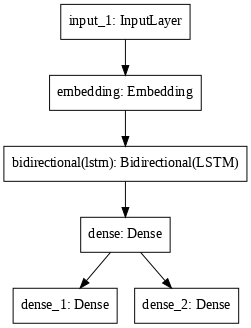

In [ ]:
def encoder_model(num_chars, embedding_dim, max_seq_len, latent_dim, n_units):

  '''
  Encoder 

  Inputs
    num_chars (int)      : Number of unique characters in dataset
    embedding_dim (int)  : Embedding dimension
    max_seq_len (int)    : max sequence length
    latent_dim (int)     : latent dimension
    n_rnn_units (int)    : number of rnn units

  Outputs
    (Keras Model Object) : takes data inputs and returns parameters of learned latent distribution 
  '''

  inputs = Input(shape = (max_seq_len, ))
  embedding = Embedding(num_chars, embedding_dim, input_length=max_seq_len, mask_zero=True)(inputs)
  x = Bidirectional(LSTM(n_units))(embedding)
  x = Dense(latent_dim*2)(x)
  mu = Dense(latent_dim)(x)
  sigma = Dense(latent_dim)(x)
  model = tf.keras.Model(inputs, outputs = [mu, sigma])
  return model

plot_model(encoder_model(num_chars, embedding_dim, max_seq_len, latent_dim, n_units), dpi=70)

reparameterization 


---


$$z = \mu + e^{0.5\sigma} * epsilon $$
$epsilon \sim \mathcal{N}(0,1)\$

In [ ]:
def reparameterization(inputs):

  
  """
  Reparameterization function--> takes mean and sigma and reparameterize with samples
   drawn from a standard normal distribution with mean 0 and standard deviation 1. 

  Inputs:
   (mu, sigma): mean and standard deviation 

  Output:
    z        : latent code 

   """
  mu, sigma = inputs
  batch_ = tf.shape(mu)[0]
  dim = tf.shape(mu)[1]
  eps = random_normal((batch_, dim))
  
  return mu + tf.exp(0.5*sigma) * eps

In [ ]:
def decoder_model(num_chars, max_seq_len, latent_dim, n_units):

  """
  Decoder 

  Inputs
    num_chars (int)      : Number of unique characters in dataset
    max_seq_len (int)    : max sequence length
    latent_dim (int)     : latent dimension
    n_gru_units (int)    : number of gru units

  Outputs
    (Keras Model Object) : takes latent vectors as inputs and returns a 
                           softmax distribution over character set 
  """


  inputs = Input(shape = (latent_dim))
  x = RepeatVector(max_seq_len)(inputs)
  lstm_out = LSTM(n_units, return_sequences=True)(x)
  output = Dense(num_chars, activation='softmax')(lstm_out)

  model = Model(inputs, output)
  return model


In [ ]:
def sample_prior(batch_size, latent_dim):

  """
  Sample prior       :  Sample for random normal distribution
  Inputs:
    batch_size (int) : number of samples to generate
    latent_dim (int) : latent dimension

  Outputs
    samples from normal distribution (size = (batch_size, latent_dim))
  """

  return random_normal((batch_size, latent_dim))

In [ ]:
def kl_divergence_loss(inputs, outputs, mu, sigma):
  
  """ 
  Computes the Kullback-Leibler Divergence (KLD) loss
  Inputs
    inputs:  batch from the dataset
    outputs: Output from the sample_z function/ layer
    mu:      mean
    sigma:   standard deviation

  Outputs:
    KL Divergence loss
  # """

  rate = 0.5
  kl_loss = 1 + sigma - tf.square(mu) - tf.math.exp(sigma)
  kl_loss = -rate * tf.reduce_mean(kl_loss)

  return kl_loss 

In [ ]:
def vae_model(encoder, decoder, max_seq_len):

  
  """
  Biulds a complete VAE model

  Inputs
    encoder     : the encoder model
    decoder     : the decoder model
    max_seq_len : length of sequence batch

  Output:
    the complete VAE model
  """

  # set the inputs
  input_x = tf.keras.layers.Input(shape=(max_seq_len, ))

  # get mu, sigma, and z from the encoder output
  mu, sigma = encoder(input_x)
  
  z = Lambda(reparameterization)(([mu, sigma]))
  # get reconstructed output from the decoder
  reconstructed = decoder(z)

  # define the inputs and outputs of the VAE
  model = tf.keras.Model(inputs=input_x, outputs=reconstructed)

  # add the KL loss
  loss = kl_divergence_loss(input_x, z, mu, sigma)
  model.add_loss(loss)

  return model

We'll use the Adam optimizer and the sparse categorical cross entropy loss function.

In [ ]:
# Define our loss functions and optimizers

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss_metric = tf.keras.metrics.Mean()
spce_loss = tf.keras.losses.SparseCategoricalCrossentropy()

In [ ]:
# Initialize vae model
def init_models(num_chars, embedding_dim, max_seq_len, latent_dim, n_units):
  """ Model initializations here """

  encoder = encoder_model(num_chars, embedding_dim, max_seq_len, latent_dim, n_units)
  decoder = decoder_model(num_chars, max_seq_len, latent_dim, n_units)
  vae = vae_model(encoder, decoder, max_seq_len)
  
  return encoder, decoder, vae

encoder, decoder, vae = init_models(num_chars, embedding_dim, max_seq_len, latent_dim, n_units)

In [ ]:
# Training loop. 

epochs = 150 # Set the number of training epochs

# prior = sample_prior(1, latent_dim)
losses = []
for epoch in range(epochs):

  # iterate over the batches of the dataset.
  for step, batch in enumerate(train_dataset):
    with tf.GradientTape() as tape:
      
      # feed a batch to the VAE model
      reconstructed = vae(batch) # Get a batch of the training examples and feed to the vae model

      loss = spce_loss(batch, reconstructed)  # compute the reconstruction loss between data and reconstruction

      loss += sum(vae.losses)   # add the KL Divergence loss to reconstruction

    grads = tape.gradient(loss, vae.trainable_weights)  # get the gradients with respect to the weights
    optimizer.apply_gradients(zip(grads, vae.trainable_weights)) # Update the weights with gradients

    loss_metric(loss) # compute the mean of losses
    losses.append(loss_metric.result().numpy())
    # # Show outputs at every 50 steps
    if step % 50 == 0:
      print('Epoch: %s step: %s average loss = %s ' % (epoch, step, loss_metric.result().numpy()))

Epoch: 0 step: 0 average loss = 3.5142984 
Epoch: 0 step: 50 average loss = 2.234938 
Epoch: 1 step: 0 average loss = 2.1737137 
Epoch: 1 step: 50 average loss = 1.9770994 
Epoch: 2 step: 0 average loss = 1.933821 
Epoch: 2 step: 50 average loss = 1.8217098 
Epoch: 3 step: 0 average loss = 1.8022401 
Epoch: 3 step: 50 average loss = 1.737471 
Epoch: 4 step: 0 average loss = 1.7224969 
Epoch: 4 step: 50 average loss = 1.6784 
Epoch: 5 step: 0 average loss = 1.6666652 
Epoch: 5 step: 50 average loss = 1.6303576 
Epoch: 6 step: 0 average loss = 1.621781 
Epoch: 6 step: 50 average loss = 1.5941923 
Epoch: 7 step: 0 average loss = 1.5875555 
Epoch: 7 step: 50 average loss = 1.5649297 
Epoch: 8 step: 0 average loss = 1.559903 
Epoch: 8 step: 50 average loss = 1.5433537 
Epoch: 9 step: 0 average loss = 1.5390197 
Epoch: 9 step: 50 average loss = 1.5226864 
Epoch: 10 step: 0 average loss = 1.5184797 
Epoch: 10 step: 50 average loss = 1.5165317 
Epoch: 11 step: 0 average loss = 1.514083 
Epoch:

In [ ]:
generate_random_smiles(decoder, 5, latent_dim, decoding_strategy='temp', temperature=0.1) # Lets generate some random samples with the trained decoder